## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [2]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?

NMF uses  100  features
Percentage of correct answer using NMF is  0.8737060041407867


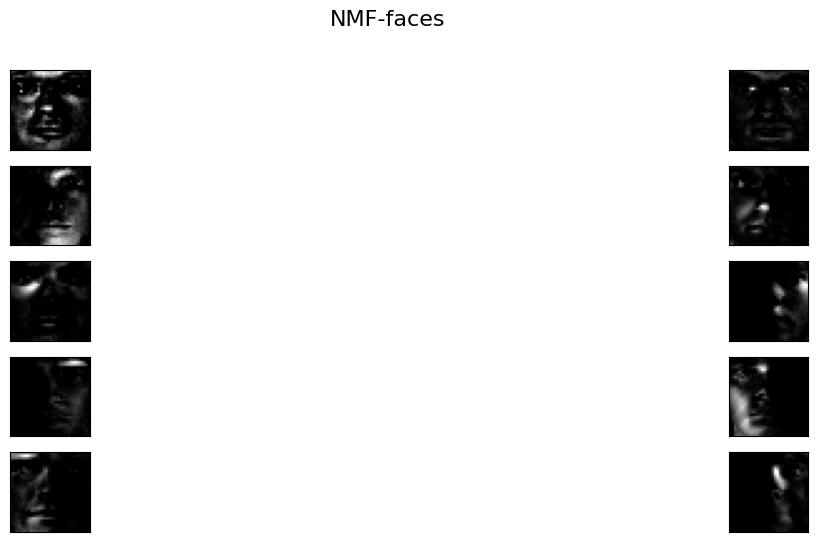

In [3]:
# NMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T,Id_Test))

PCA components can have both positive and negative values, which allows them to capture both the presence and absence of features in the data. The eigenfaces tend to be more holistic and ghostly images, capturing the most significant variations across all faces.

NMF, on the other hand, is a factorization method that approximates the data as a linear combination of non-negative basis components. It is often used in parts-based representation because it allows only additive, not subtractive, combinations. In terms of face images, this leads to "parts of faces" being represented. NMF components (or "NMF-faces") tend to represent localized features such as eyes, noses, or mouths. These are more interpretable as parts of faces compared to eigenfaces since they cannot subtract out features, only add them.

PCA is typically better for capturing the overall structure and for tasks where negative contributions from features are meaningful, while NMF is better for interpretability and when you want strictly additive combinations, which can be advantageous in certain contexts such as parts-based recognition. 

3. What about the performances of NMF, i.e. computational time and classification accuracy ?

    PCA is generally faster than NMF because it is a closed-form solution. For large datasets, PCA can be efficiently computed using randomized algorithms that approximate the leading components. NMF often requires more computational time compared to PCA. It is an iterative algorithm, usually optimized through alternating updates (like multiplicative update rules or alternating least squares). The number of iterations until convergence can vary widely based on the initialization, the complexity of the data, and the stopping criteria.

    Focusing on other aspects, PCA may lead to better classification accuracy in scenarios where the most significant sources of variance in the data are relevant for class discrimination. Since PCA preserves global structure and maximizes variance, it can capture features that are important for distinguishing between different classes. NMF can result in better classification accuracy when the classification relies on the recognition of localized, additive features. Because NMF components are non-negative and parts-based, they can sometimes offer more meaningful feature representations for classification tasks, particularly when the interpretability of features is crucial.

4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

    Using PCA before NMF is a strategy that can be considered under certain circumstances, but whether it's a good idea depends on the goals of the analysis and the characteristics of the dataset:

    1. PCA can be used as a pre-processing step to reduce the dimensionality of the data before applying NMF. This can be particularly useful if the dataset is very high-dimensional and sparse, which can make NMF computationally expensive and potentially less stable.

    2. PCA can also help in denoising the data. By keeping only the principal components that explain a significant amount of variance, PCA can filter out noise and irrelevant details, which might lead to a cleaner and more robust input for NMF.

    3. PCA imposes an orthogonality constraint on its components, which means that the reduced space consists of directions that are linearly independent. This can potentially make the NMF components more interpretable because they would be built from a space where the base vectors do not overlap in terms of variance explained.

    However, one potential downside of using PCA before NMF is that PCA can introduce negative values in the reduced representation, which goes against the non-negativity constraint of NMF. This means that the PCA-transformed data no longer adheres to the additive parts-based representation that makes NMF appealing. 
    
    Another down effect of PCA before NMF, is that it adds additional computational steps. If computational efficiency is a primary concern, this approach might not be the best.

    The effectiveness of using PCA before NMF for a task such as classification or clustering would need to be empirically validated. It's possible that PCA could remove variance that is actually informative for the subsequent NMF and the task at hand.

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [4]:
def NNMFLecture(X, r=None, N_Iter=1000, tolerance=1e-3, plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r = X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d, N = X.shape
   
    # Initialization
    W = np.random.rand(d, r)
    H = np.random.rand(r, N) 
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps = np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method
        
        XH = np.dot(X, H.T)
        HH = np.dot(H, H.T)
        for i in range(20):
            W = np.multiply(W, np.divide(XH, np.dot(W, HH) + eps))
                       
        H = np.multiply(H, np.divide(np.dot(W.T, X), np.dot(np.dot(W.T, W), H) + eps))

        # Convergence indices
        k = k + 1           
        diff = X - np.dot(W, H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k == 1 or k % 100 == 0:
            print('Iteration NMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k == N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution == 1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NMF')
        plt.show()
    
    return W,H

Iteration NMF number  1  out of  300 , delta =  0.5305520922150734 , error (norm delta):  273.1053383416712
Iteration NMF number  100  out of  300 , delta =  0.1587322988286227 , error (norm delta):  81.70854250400153
Iteration NMF number  200  out of  300 , delta =  0.15113102497775255 , error (norm delta):  77.7957345114773
Iteration NMF number  300  out of  300 , delta =  0.14851209321619924 , error (norm delta):  76.44762137550492
Maximum number of iterations reached ! delta =  0.14851209321619924


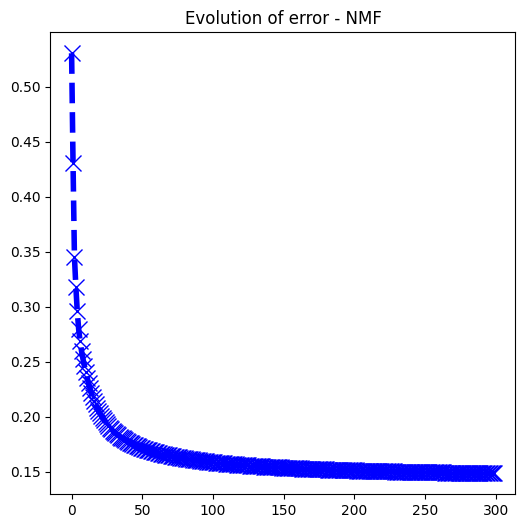

NMF uses  100  features
Percentage of correct answer using NMF is  0.8612836438923396


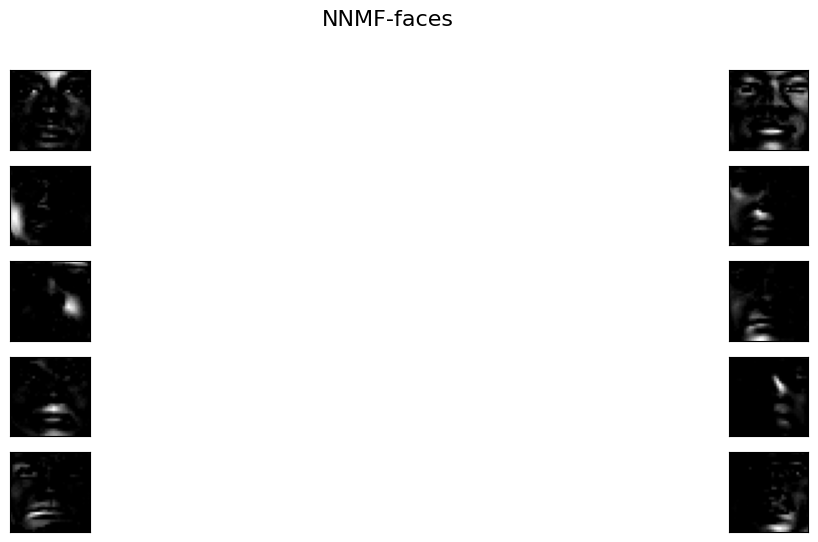

In [5]:
# NMF (your own implementation)
Ncomponents = 100
Wtrain_nnmf, Htrain_nnmf = NNMFLecture(Xtrain.T, r = Ncomponents, N_Iter = 300,
                                      tolerance = 1e-3, plot_evolution = 1)
plotFaces(Wtrain_nnmf.T, r, c, ncol = 2, indeces = np.arange(0,10,1), title = 'NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf), Xtest.T)

print('NMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T, Id_Train.ravel())
print('Percentage of correct answer using NMF is ', NN.score(Htest_nnmf.T, Id_Test))

- What do you observe?

    The NMF algorithm appears to have decomposed the faces into parts or features that are non-negative. Each image represents a basis component that captures some specific feature of the face, such as edges, contours, or contrasts in particular regions (like the eyes, nose, mouth, etc.). These components are generally more interpretable than the principal components obtained from PCA. 

- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

    The inversion step for `Htest_nnmf` involves computing the pseudo-inverse of `Wtrain_nnmf` to project the test data into the same feature space created by NMF for the training data:

    1. Computing the pseudo-inverse does not guarantee that the resulting `Htest_nnmf` will maintain this non-negativity. This can be problematic since the interpretability of NMF relies on the additive, parts-based representation that comes from non-negative factors.

    2. The pseudo-inverse is an approximation that may not perfectly reconstruct the original data when applied to the test set. This can introduce reconstruction errors, especially if `Wtrain_nnmf` is rank-deficient or ill-conditioned.

    3. Using the pseudo-inverse of `Wtrain_nnmf` assumes that the test data will have the same distribution and span the same subspace as the training data. If there is a significant difference between the training and test datasets, this can lead to poor generalization and performance.

    To avoid these limitations:

    - Apply a form of NMF that incorporates regularization to encourage sparsity or add constraints that help with the stability and generalization of the decomposition.

    - Rather than inverting `Wtrain_nnmf`, directly apply the NMF transformation to the test data using the same NMF model (i.e., the same initialization and constraints) used for the training data. This ensures that the non-negativity constraint is preserved and that the same feature space is used.

## I-3) ICA and NMF in the presence of noise

We will now compare ICA and NMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.

    When noise is introduced into the dataset, specifically Gaussian noise \( N \), the model would become \( X = AS + N \):

    1. ICA is typically more robust to noise when the signal-to-noise ratio (SNR) is relatively high. However, when noise is present, especially if it's Gaussian, it can complicate the ICA since the assumption of non-Gaussianity is crucial for the separation of the independent components. Gaussian distributions, by definition, do not have the non-Gaussian features that ICA relies upon to distinguish between components.

    2. The performance of ICA can degrade significantly in the presence of Gaussian noise, which can be symmetrical and lack the higher-order statistical structure that ICA exploits. The independent components extracted in the presence of substantial Gaussian noise might not represent the underlying signals accurately and may be more difficult to interpret.

    3. ICA usually involves a pre-whitening step that makes the observed signals uncorrelated and with unit variance. This step can sometimes amplify the noise, especially if the noise is uncorrelated, which most Gaussian noise is.

2. On the other hand, do you think that NMF behaves better? If so, for what kind of noises?

    NMF can handle certain types of noise better than others. It tends to be more robust against noise that is additive and non-negative, as the model itself is built upon additive, non-negative components. This makes NMF particularly suitable for datasets where the noise can be thought of as additive "clutter" or slight variations in the measurements.

    If the noise is Gaussian but strictly positive, NMF could still perform reasonably well, especially if the signal-to-noise ratio is high. However, if the Gaussian noise includes negative values, this could pose a problem for NMF since it violates the non-negativity constraint of the model. In practice, negative values in the noise could be set to zero, but this would introduce a bias in the noise model.

    NMF can be made more robust to noise by incorporating regularization terms into the optimization problem. For instance, adding sparsity constraints can help the algorithm focus on the most important features and ignore noisy components. Other variations of NMF, such as Convex-NMF or Sparse NMF, can also be used depending on the noise characteristics and the application at hand.

In the following, we will try to compare the behavior of ICA and NMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NMF are used as pre-processing steps. Comment your results.

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8881987577639752
ICA uses  250  features
Percentage of correct answer using ICA is  0.9213250517598344
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8757763975155279
ICA uses  250  features
Percentage of correct answer using ICA is  0.8674948240165632
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8757763975155279
ICA uses  250  features
Percentage of correct answer using ICA is  0.3084886128364389
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8053830227743272
ICA uses  250  features
Percentage of correct answer using ICA is  0.09730848861283643
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.6770186335403726
ICA uses  250  features
Percentage of correct answer using ICA is  0.062111801242236024
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.4720496894409938
ICA uses  250  features
Percentage of c

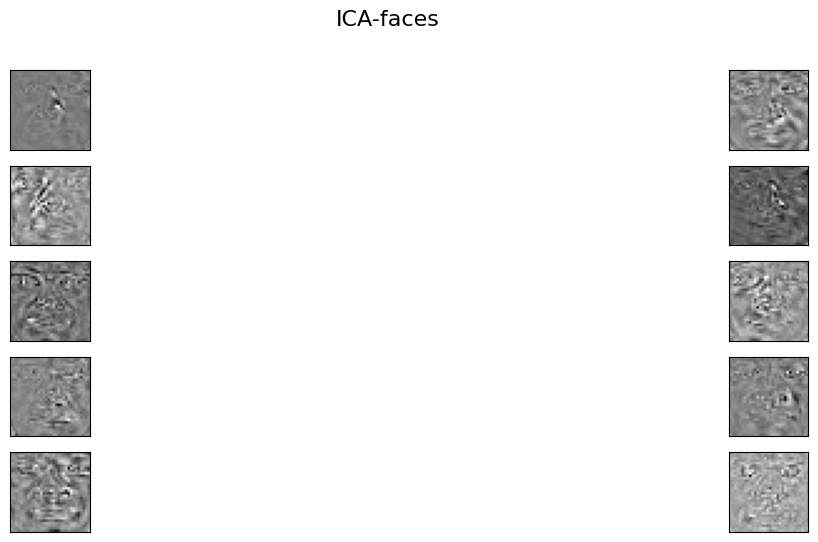

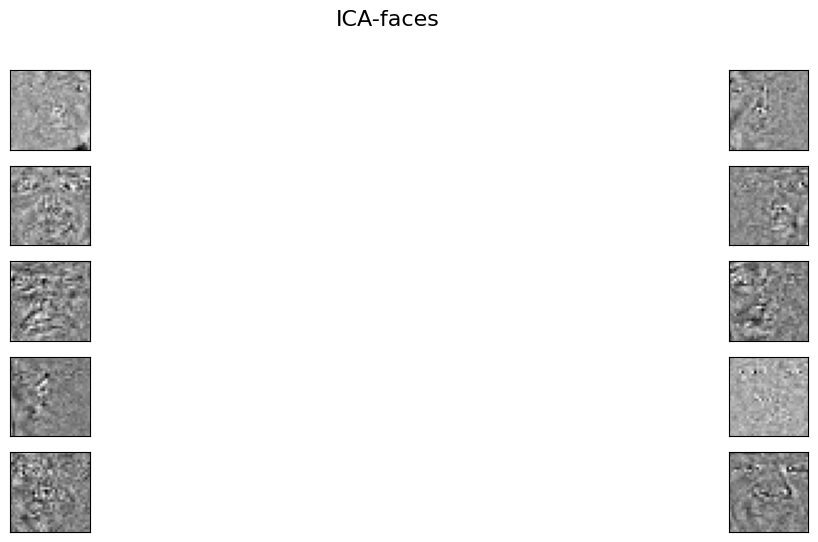

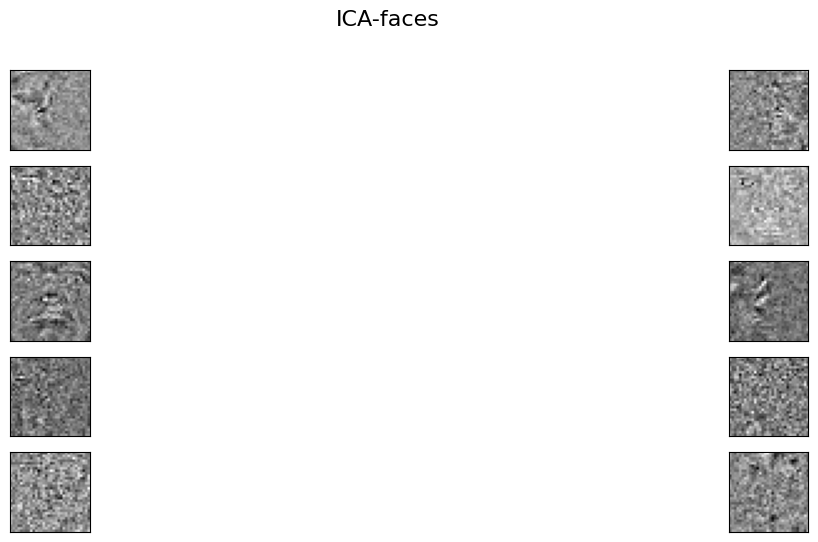

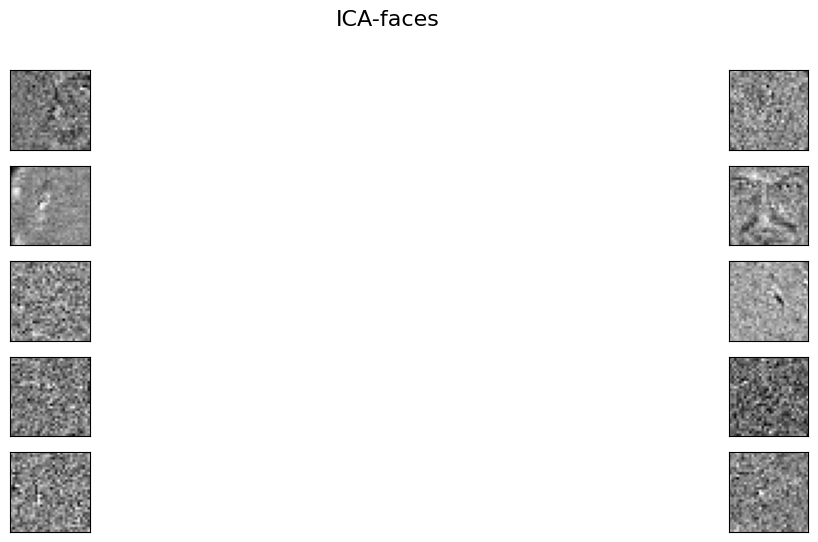

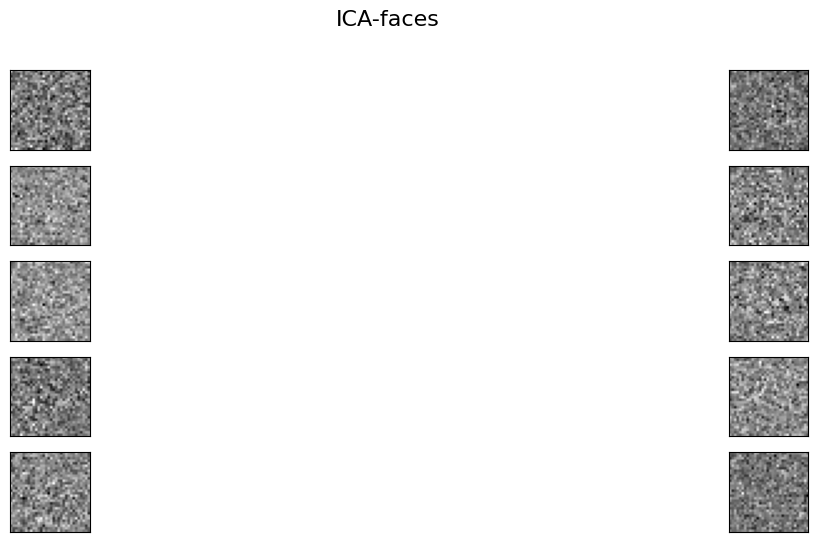

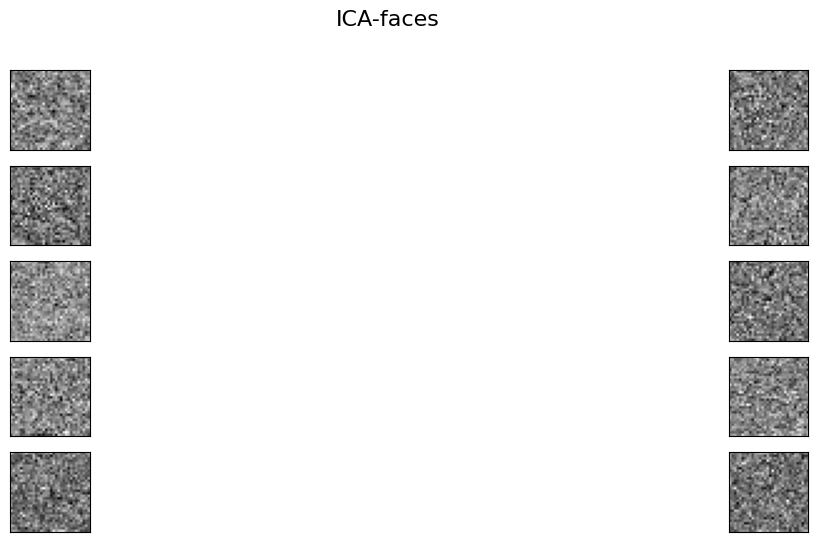

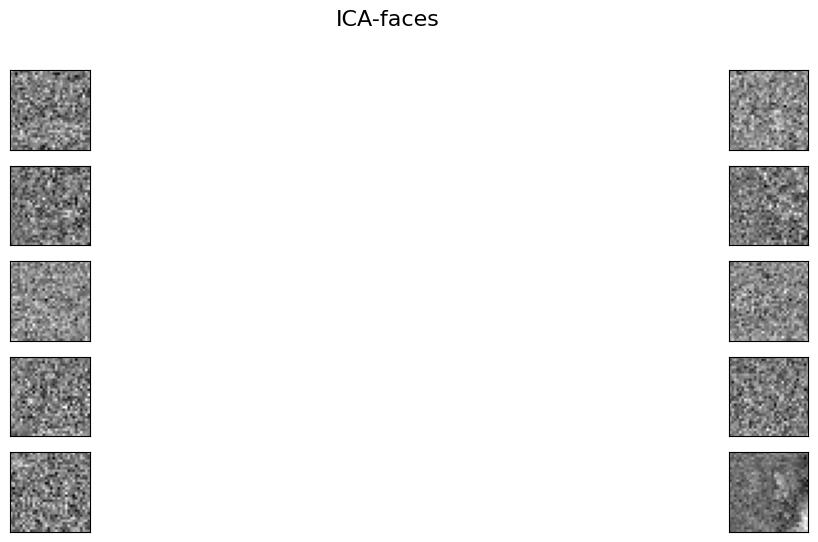

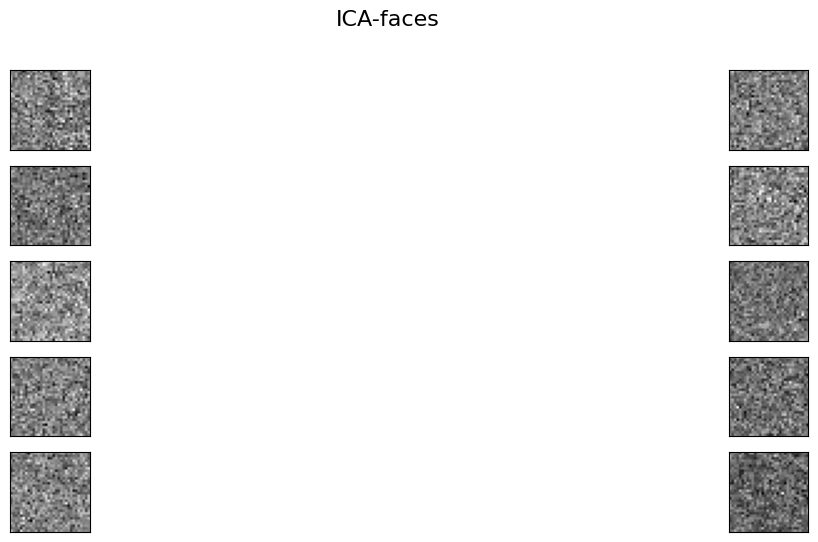

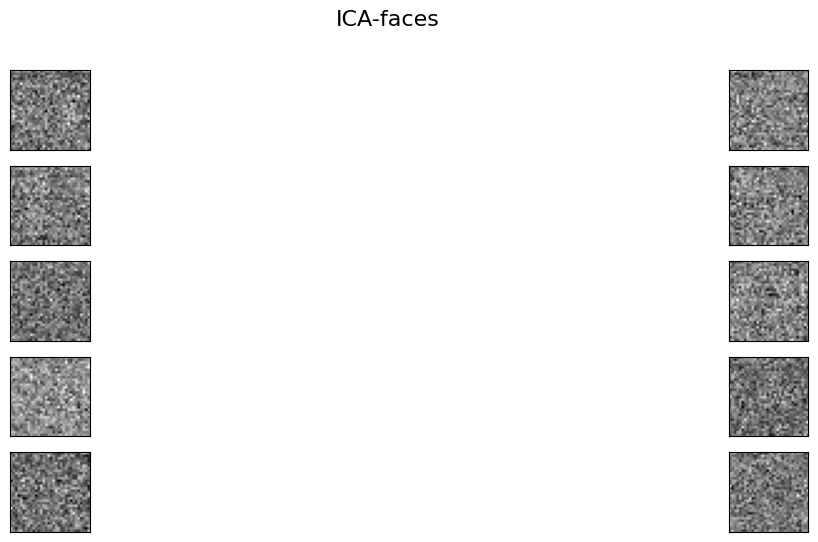

In [21]:
sigmaTab = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation, with gaussian noise
    XtrainNoise = abs(Xtrain + sigmaTab[i] * np.random.randn(Xtrain.shape[0],Xtrain.shape[1]))
    XtestNoise = abs(Xtest + sigmaTab[i] * np.random.randn(Xtest.shape[0],Xtest.shape[1]))
    
    ##################

    # NMF
    Ncomponents=250
    model = NMF(init = 'random', solver = 'mu', n_components = Ncomponents, 
                tol = 1e-3, max_iter = 300, random_state = 0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF), Xtest.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN = KNeighborsClassifier(n_neighbors = 1)
    NN.fit(HtrainNNMF.T, Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T, Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T, Id_Test)

    ##################

    ## ICA (you don't have anything to change here)
    # Second architecture (scikit-learn implementation)
    XctestNoise = XtestNoise - np.mean(XtestNoise, axis=0) # centering
    XctrainNoise = XtrainNoise - np.mean(XtrainNoise, axis=0) # centering
    
    # Second architecture (scikit-learn implementation).
    pca = PCA(random_state=1) 
    YpcaTrain = pca.fit_transform(XctrainNoise)
    UpcaTrain = pca.components_.T # we want PC on columns
    var_explained_pca = pca.explained_variance_ratio_

    # We use the PCA projection to speed up results
    PCAComp = 250

    # Selection of the eigenvectors 
    Yr_train_PCA = YpcaTrain[:,:PCAComp]
    Ur_train_PCA = UpcaTrain[:,:PCAComp]
    Yr_test_PCA = np.dot(XctestNoise,Ur_train_PCA)

    ICA = FastICA(whiten = 'arbitrary-variance', fun = 'exp', max_iter = 30000, 
                 tol = 1e-4, algorithm = 'parallel', random_state = 1)
    Yica = ICA.fit_transform(Yr_train_PCA)
    S_train_ICA = Yica.T
    W_train_ICA = ICA.components_

    ICAFAces = np.dot(Ur_train_PCA,W_train_ICA.T) 
    Y_train_ICA = S_train_ICA
    Y_test_ICA = np.dot(W_train_ICA,Yr_test_PCA.T)

    # Plot the ICA-faces
    plotFaces(ICAFAces.T, r, c, ncol=2, indeces = np.arange(0,10,1), title = 'ICA-faces')      

    print('ICA uses ', Y_train_ICA.shape[0], ' features')

    # Score ICA
    NN.fit(Y_train_ICA.T, Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(Y_test_ICA.T, Id_Test.ravel()))
    scoreICA[i] = NN.score(Y_test_ICA.T, Id_Test.ravel())

Text(0, 0.5, 'Score')

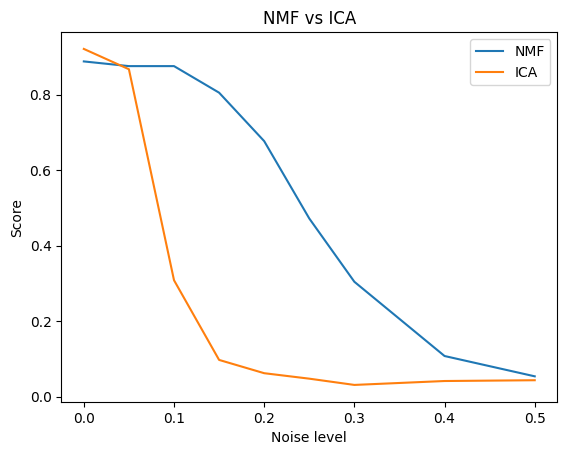

In [22]:
plt.figure()
plt.plot(sigmaTab, scoreNMF)
plt.plot(sigmaTab, scoreICA)
plt.legend(['NMF', 'ICA'])
plt.title('NMF vs ICA')
plt.xlabel('Noise level')
plt.ylabel('Score')

NMF declines more gradually compared to ICA as the noise level increases. This indicates that NMF is relatively more robust to Gaussian noise in this scenario. The slower decline suggests that the additive, part-based features that NMF extracts are still somewhat discernible even as the noise level increases.

ICA shows a sharper decline as the noise level goes up. This implies that ICA is more sensitive to Gaussian noise in this context. The performance drop could be due to the fact that Gaussian noise impacts the statistical independence of the sources, which is a key assumption for ICA.

At very high noise levels (around 0.5), both methods converge to a similar performance level, indicating that beyond a certain point, the noise overwhelms the signal to the extent that neither method can effectively extract useful features.

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [8]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None, X1 = None, y = None, U = None, Y = None, const = 1, title = ''):

    X = np.concatenate((X0,X1),axis=0)
    
    N0 = np.sum(y == 0)
    N1 = np.sum(y == 1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0], X0[:,1], c = 'r', label = 'Class 0')
    plt.scatter(X1[:,0], X1[:,1], c = 'b', label = 'Class 1')
    if U is not None:
        average = X.mean(axis = 0)
        sd = LA.norm(X.std(axis=0))
        u0 = U[:,0]*const*sd;
        u1 = U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

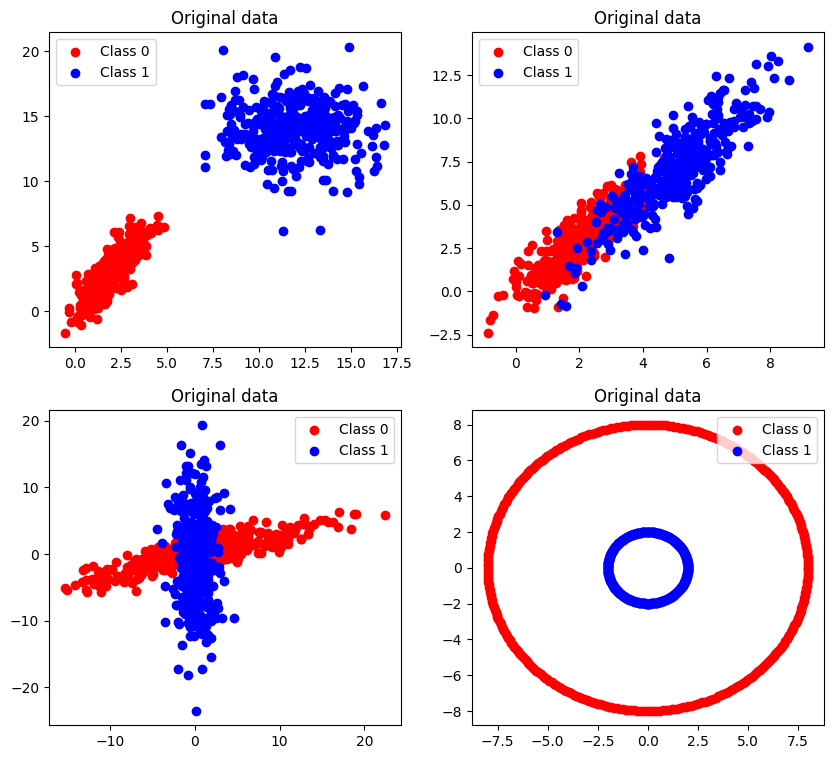

In [9]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4

plt.figure(figsize=(10, 9))
for i in range(1,5):
    X0, X1, y = generate_scenario(scenario = i, n_samples0 = 350, n_samples1 = 350)

    plt.subplot(2,2,i)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    plt.title('Original data')
    plt.legend()
    
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 

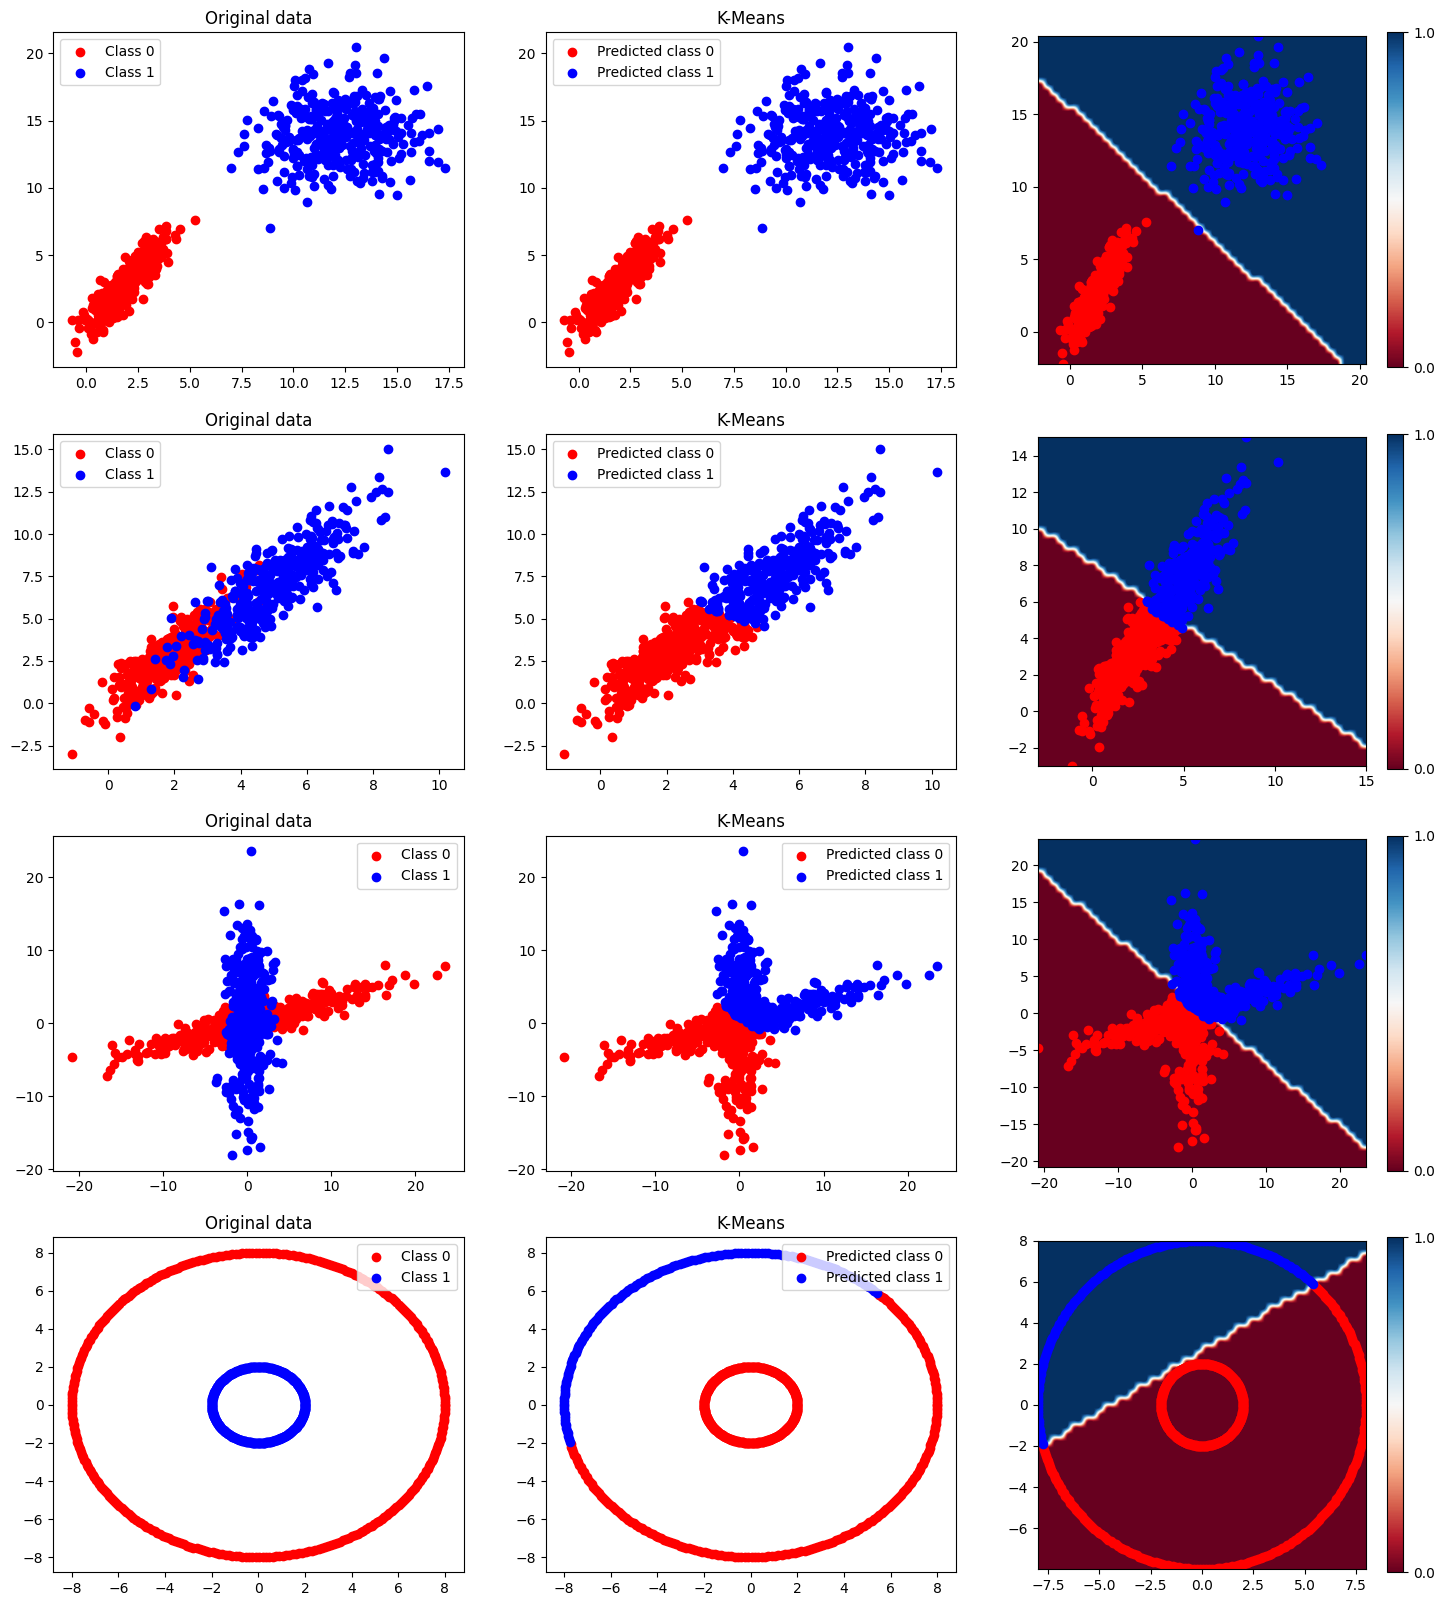

In [10]:
plt.figure(figsize=(18, 20))

for i in range(1,5):

    X0, X1, y = generate_scenario(scenario = i, n_samples0 = 350, n_samples1 = 350)
    X = np.concatenate((X0,X1),axis=0)
    
    ## K-means
    Ncluster = 2 # choose a number of clusters
    kmeans = KMeans(n_clusters = Ncluster) 
    yKmeans = kmeans.fit_predict(X)

    plt.subplot(4, 3, 1 + 3*(i-1)) 
    plt.scatter(X[np.where(y == 0)[0],0], X[np.where(y == 0)[0],1],c='r', label='Class 0')
    plt.scatter(X[np.where(y == 1)[0],0], X[np.where(y == 1)[0],1],c='b', label='Class 1')
    plt.title('Original data')
    plt.legend()

    plt.subplot(4, 3, 2 + 3*(i-1))
    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
    plt.title('K-Means')
    plt.legend()

    plt.subplot(4, 3, 3 + 3*(i-1))
    frontiere(kmeans, X, y, step=50)

    
plt.show()

**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?
    
    K-means tends to fail on non-linearly separable data because it uses the mean value of the members of a cluster as its centroid and minimizes the variance within a cluster, which inherently assumes linear boundaries. If clusters have different densities, K-means may not correctly identify the true clusters because it does not account for density, only distance to the centroid. 

    The K-means algorithm assumes that clusters are circular (or spherical in higher dimensions), so it may not work well with clusters of different shapes and sizes. This is also sensitive to outliers. Since the algorithm works by minimizing the sum of squared differences, outliers can have a large impact on the position of the centroid, skewing the results.

    Determining the Correct Number of Clusters: 

    - Sometimes, the correct number of clusters is known a priori due to domain knowledge, which makes the choice straightforward.
    - When the number of clusters is not known, the elbow method can be used to estimate it. This method involves plotting the within-cluster sum of squares against the number of clusters and looking for the "elbow" point where the rate of decrease sharply changes. 
    
    In practice, the choice of the number of clusters is often not clear cut and may require several runs of the algorithm with different numbers of clusters, along with a qualitative assessment of the resulting clusters. 

    K-means performed well on the first scenario (clearly separated blobs) and poorly on others (concentric circles and non-spherical distributions). These limitations are inherent to the assumptions K-means makes about the data. 

Now, implement your own K-means using the Lloyd's algorithm.

In [11]:
def KMeansLecture(X, K=2, tol=1e-4, max_iters=1000):
    
    d, N = X.shape  # Size
    muTab = X[np.random.choice(d, K, replace=False)]  # Initialization
    yKmeans = np.zeros(d)
    delta = np.inf
    k = 0

    while delta > tol and k < max_iters:
        # Assign each point to the closest centroid
        for i in range(d):
            dist = np.linalg.norm(X[i] - muTab, axis=1)
            yKmeans[i] = np.argmin(dist)

        # Update the centroids
        new_muTab = np.array( [X[yKmeans == k].mean(axis=0) for k in range(K)] )

        # Convergence indices
        delta = LA.norm(new_muTab - muTab)
        muTab = new_muTab

        k += 1

    return yKmeans, muTab

Now, test your K-means algorithm.

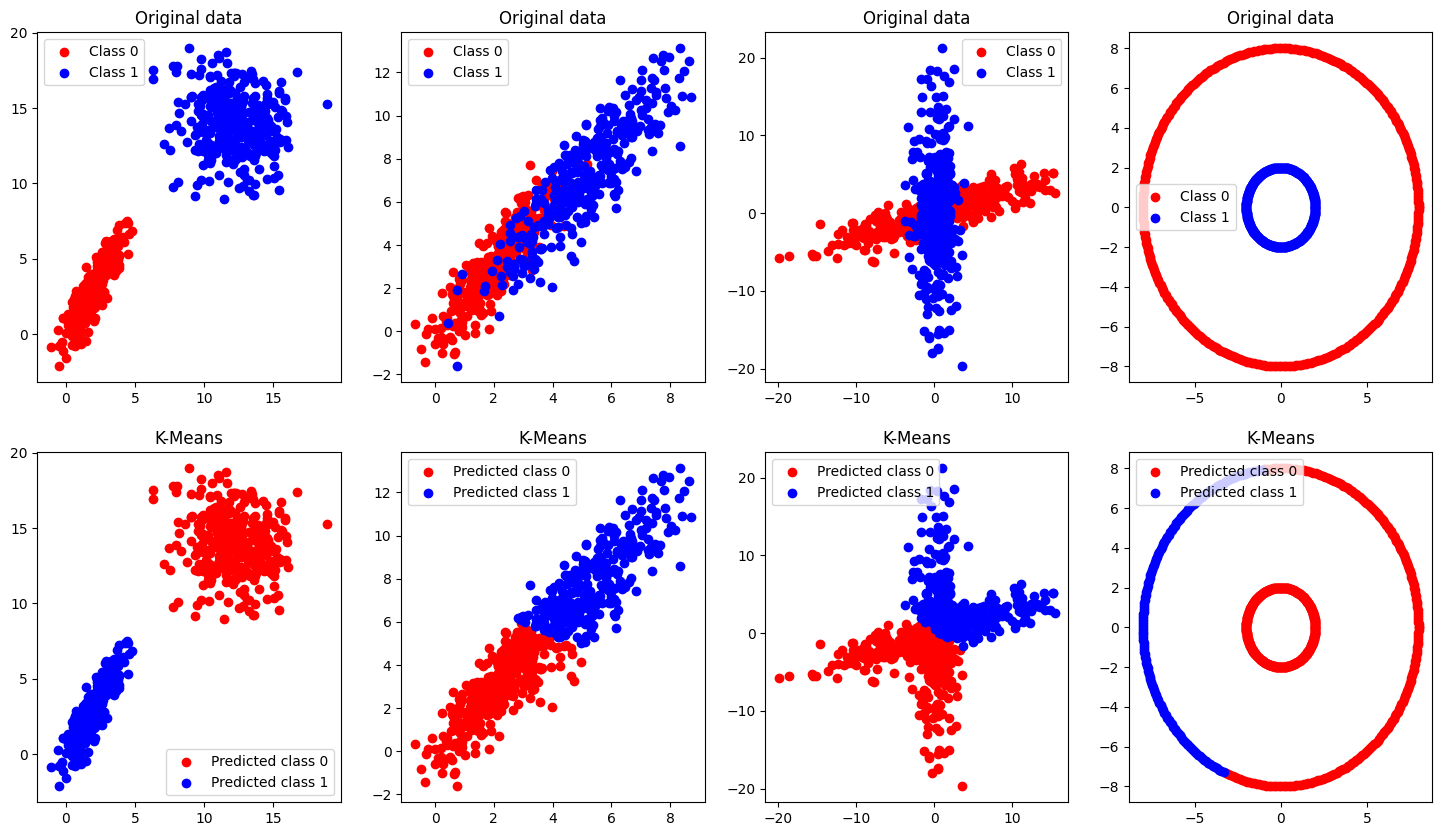

In [12]:
## K-means

plt.figure(figsize=(18, 10))
for i in range(1, 5):
    X0, X1, y = generate_scenario(scenario = i, n_samples0 = 350, n_samples1 = 350)
    X = np.concatenate((X0,X1),axis=0)

    Ncluster= 2 # choose a number of clusters
    yKmeans, muTab = KMeansLecture(X, K = Ncluster, tol = 1e-4)

    plt.subplot(2, 4, i)
    plt.scatter(X[np.where(y == 0)[0],0], X[np.where(y == 0)[0],1], c = 'r', label = 'Class 0')
    plt.scatter(X[np.where(y == 1)[0],0], X[np.where(y == 1)[0],1], c = 'b', label = 'Class 1')
    plt.title('Original data')
    plt.legend()

    plt.subplot(2, 4, i + 4)
    plt.scatter(X[np.where(yKmeans == 0)[0],0], X[np.where(yKmeans == 0)[0],1], c = 'r', label = 'Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0], X[np.where(yKmeans == 1)[0],1], c = 'b', label = 'Predicted class 1')
    plt.title('K-Means')
    plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


(-0.5, 374.5, 280.5, -0.5)

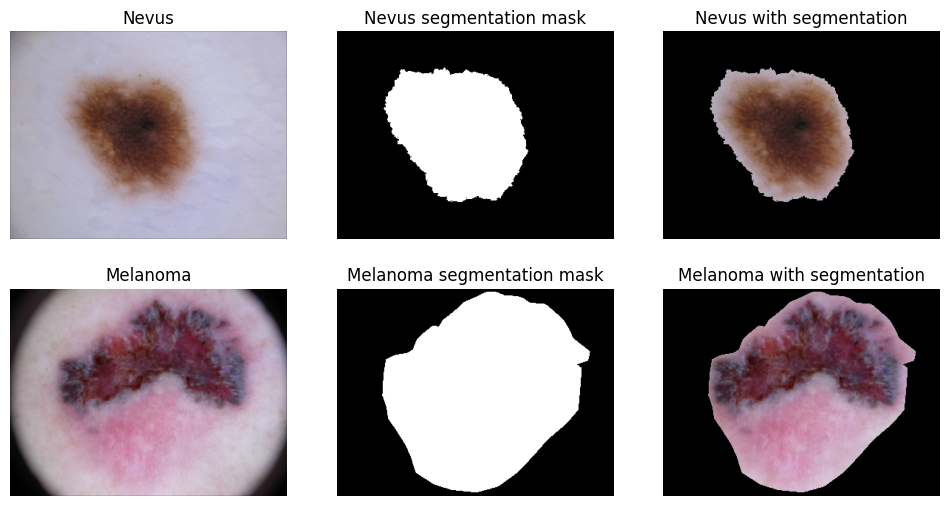

In [13]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/" 

# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)

# We rescale to speed up computations
nevus = rescale(nevus, 0.25, channel_axis = 2,anti_aliasing=True)

# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25, channel_axis = 2,anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')

grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')

grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')

grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')

grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')

grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')


**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

    For segmentation tasks like this one, \( K \) would usually be 2:

    1. **Class 0 (Background)**: The area that does not contain the lesion and is not of interest.
    2. **Class 1 (Lesion)**: The area representing the nevus or melanoma, which is the focus of the analysis.

    Both nevus and melanoma images would typically use the same \( K = 2 \) because the task is to separate the lesion from the background, regardless of the type of lesion. The goal of the segmentation is not to classify the type of lesion but to delineate the lesion's boundaries.

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

    The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

The dice score is  0.6729886506935687  for channel  0
The dice score is  0.7888299851190477  for channel  1
The dice score is  0.8296033581000696  for channel  2


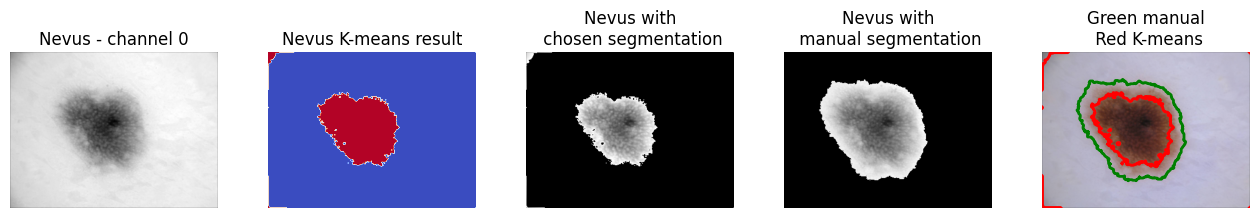

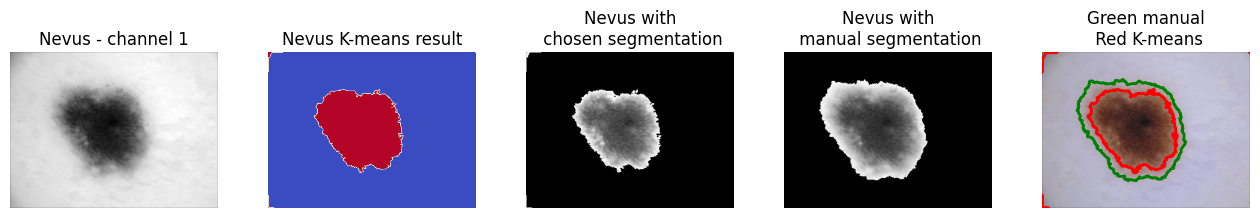

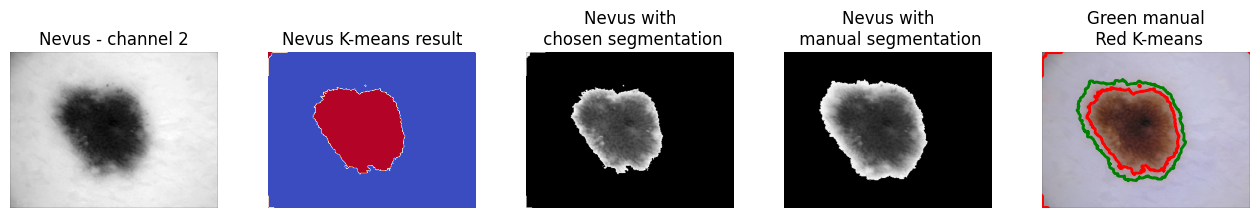

In [26]:
## NEVUS

for channel in range(3):

  nevusB = nevus[:,:,channel] 

  # Select the number of cluster K to look for 
  K = 2 # choose a number of clusters

  kmeans = KMeans(n_clusters=K, random_state=1) 
  labels = kmeans.fit_predict(nevusB.reshape(-1,1))
  labels = np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

  # Depending on the number of classes K, K-means returns one integer per pixel 
  # which indicates the number of the cluster. 
  # Choose the integer to use as mask between 0 and K-1
  index = 1
  mask = labels == index ## choose which label should be

  contourMask = find_contours(mask, 0.5)
  contourManual = find_contours(nevusMask_boolean, 0.5)

  # plot the results
  fig = plt.figure(figsize=(16, 12))
  grid = AxesGrid(fig, 111,
                  nrows_ncols = (1, 5),
                  axes_pad = 0.5)
  grid[0].imshow(nevusB,cmap='gray')
  grid[0].set_title('Nevus - channel ' + str(channel))
  grid[0].axis('off')

  grid[1].imshow(labels,cmap='coolwarm')
  grid[1].set_title('Nevus K-means result')
  grid[1].axis('off')

  grid[2].imshow(mask*nevusB,cmap='gray')
  grid[2].set_title('Nevus with\n chosen segmentation')
  grid[2].axis('off')

  grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
  grid[3].set_title('Nevus with\n manual segmentation')
  grid[3].axis('off')

  grid[4].imshow(nevus)
  for contour in contourMask:
    grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
  for contour in contourManual:
    grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
  grid[4].set_title('Green manual\n Red K-means')
  grid[4].axis('off')

  # Compute the dice score between your mask and the manual segmentation 
  print('The dice score is ', 1-dice(np.squeeze(nevusMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1))), ' for channel ', channel)
  # (0 for Red, 1 for Green and 2 for Blue)

The dice score is  0.4982305769293205  for channel  0
The dice score is  0.5217952113876381  for channel  1
The dice score is  0.5177258372183218  for channel  2


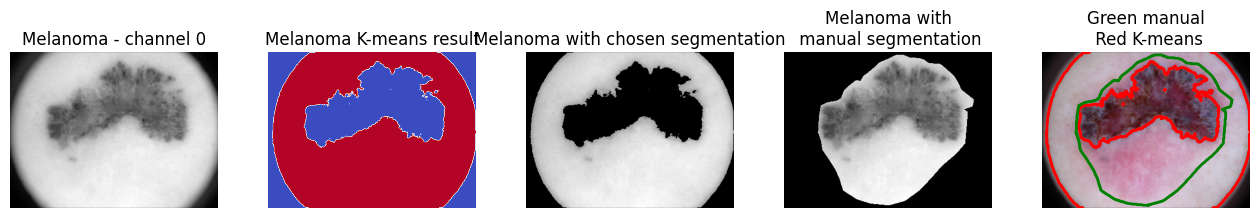

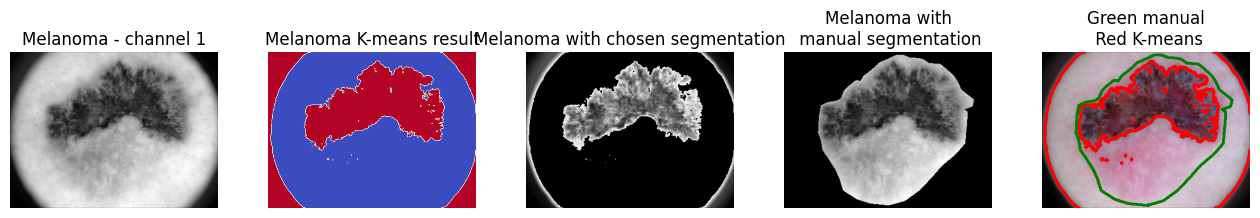

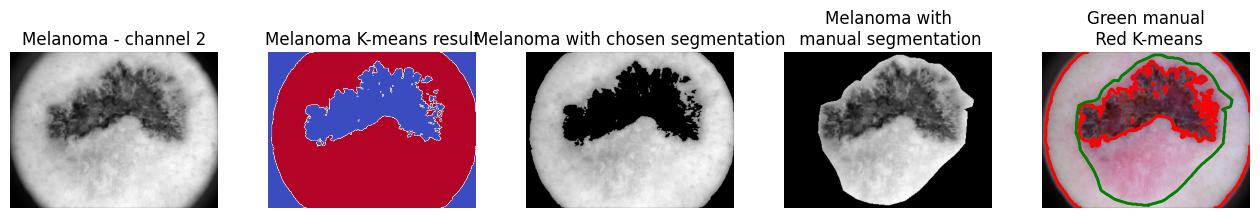

In [27]:
## MELANOMA
for channel in range(3):

  melanomaB = melanoma[:,:,channel]

  # Select the number of cluster K to look for 
  K = 2 # choose a number of clusters

  kmeans=KMeans(n_clusters=K) 
  labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
  labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

  # Depending on the number of classes K, K-means returns one integer per pixel 
  # which indicates the number of the cluster. 
  # Choose the integer to use as mask between 0 and K-1
  index =1
  mask=labels==index ## choose which label should be

  contourMask = find_contours(mask, 0.5)
  contourManual = find_contours(melanomaMask_boolean, 0.5)

  fig = plt.figure(figsize=(16, 12))
  grid = AxesGrid(fig, 111,
                  nrows_ncols = (1, 5),
                  axes_pad = 0.5)
  grid[0].imshow(melanomaB,cmap='gray')
  grid[0].set_title('Melanoma - channel ' + str(channel))
  grid[0].axis('off')

  grid[1].imshow(labels,cmap='coolwarm')
  grid[1].set_title('Melanoma K-means result')
  grid[1].axis('off')

  grid[2].imshow(mask*melanomaB,cmap='gray')
  grid[2].set_title('Melanoma with chosen segmentation')
  grid[2].axis('off')

  grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
  grid[3].set_title('Melanoma with\n manual segmentation')
  grid[3].axis('off')

  grid[4].imshow(melanoma)
  for contour in contourMask:
    grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
  for contour in contourManual:
    grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
  grid[4].set_title('Green manual\n Red K-means')
  grid[4].axis('off')

  print('The dice score is ', 1 - dice(np.squeeze(melanomaMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1))), ' for channel ', channel)
  # (0 for Red, 1 for Green and 2 for Blue)

Text(0, 0.5, 'Score')

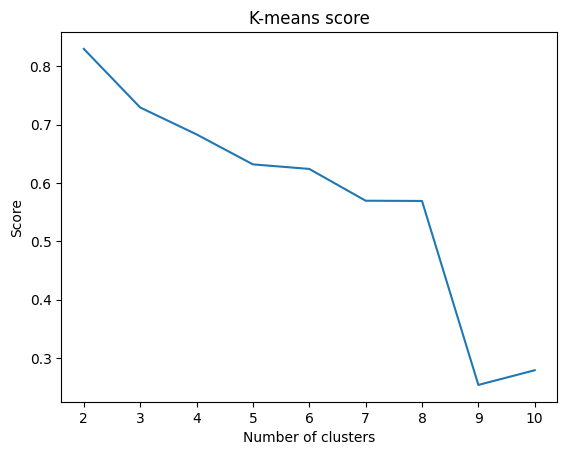

In [28]:
# Variying the number of clusters K from 2 to 10
Ktab = np.arange(2,11,1)
scoreKmeans = np.zeros(len(Ktab))
channel = 2
nevusB = nevus[:,:,channel] 

for i in range(len(Ktab)):
    kmeans = KMeans(n_clusters = Ktab[i], random_state = 1) 
    labels = kmeans.fit_predict(nevusB.reshape(-1,1))
    labels = np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))
    index = 1
    mask = labels == index ## choose which label should be
    scoreKmeans[i] = 1 - dice(np.squeeze(nevusMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1)))

plt.figure()
plt.plot(Ktab, scoreKmeans)
plt.title('K-means score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')


Text(0, 0.5, 'Score')

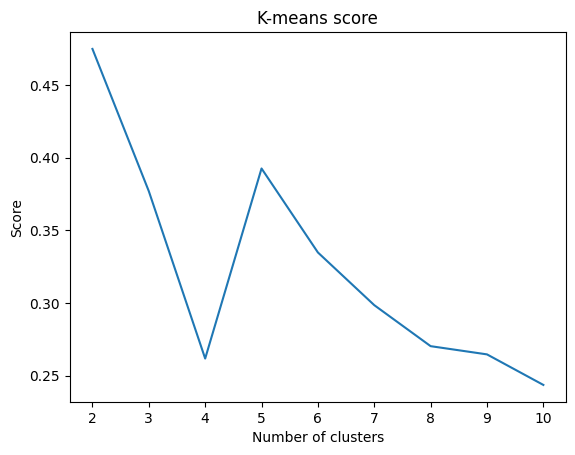

In [29]:
# Variying the number of clusters K from 2 to 10
Ktab = np.arange(2,11,1)
scoreKmeans = np.zeros(len(Ktab))
channel = 2
melanomaB = melanoma[:,:,channel]

for i in range(len(Ktab)):
    kmeans = KMeans(n_clusters = Ktab[i], random_state = 1) 
    labels = kmeans.fit_predict(melanomaB.reshape(-1,1))
    labels = np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))
    index = 1
    mask = labels == index ## choose which label should be
    scoreKmeans[i] = 1 - dice(np.squeeze(melanomaMask_boolean.reshape(1,-1)), np.squeeze(mask.reshape(1,-1)))

plt.figure()
plt.plot(Ktab, scoreKmeans)
plt.title('K-means score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')

### Color Channel Selection:
- **Red Channel**: It typically highlights hemoglobin and can be useful to emphasize blood vessels and inflammation. For skin lesions, the red channel enhances the appearance of darker areas within a lesion.
  
- **Green Channel**: It can be helpful for contrast enhancement, especially since it often suppresses skin tone variations while enhancing pigmentation differences.

- **Blue Channel**: It is usually less useful in enhancing skin lesions since it tends to be noisy and does not provide as much contrast for pigmented skin features.

### Number of Clusters \( K \):
- For segmentation purposes, you generally start with \( K = 2 \) (lesion and non-lesion). However, there may be cases where a higher \( K \) might capture additional features within the lesion, such as different pigmentation levels or structures within the lesion.

3. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

    To modify Lloyd's algorithm to constrain the centroids to always be one of the original observations, we can use the K-medoids algorithm. K-medoids is similar to K-means but instead of calculating the mean of the items in each cluster as the cluster center, it selects the most centrally located data point within the cluster as the medoid.

    1. **Initialize**: Select \( K \) initial medoids from the dataset. This can be done randomly or based on some heuristic.

    2. **Assignment Step**: Assign each data point to the closest medoid. "Closest" here can be defined using various distance metrics, commonly Euclidean distance in the same way as K-means.

    3. **Update Step**: For each cluster, find the data point that minimizes the sum of distances to all other points in that cluster. This point becomes the new medoid for that cluster.

    4. **Repeat**: Alternate between the assignment step and the update step until the medoids no longer change, or the changes do not significantly affect the sum of within-cluster distances.

    ```python
    import numpy as np

    def KMedoids(D, K, max_iters=100):
        # D is the distance matrix
        # K is the number of clusters

        # Initialize medoids randomly
        medoids = np.random.choice(D.shape[0], K, replace=False)
        prev_medoids = np.zeros(K)
        iter = 0
        
        while not np.array_equal(medoids, prev_medoids) and iter < max_iters:
            iter += 1
            
            # Assignment step
            clusters = assign_to_closest_medoids(D, medoids)
            
            # Update step
            prev_medoids = medoids.copy()
            medoids = compute_new_medoids(D, clusters, K)

        return medoids, clusters

    def assign_to_closest_medoids(D, medoids):
        clusters = {}
        for i in range(len(D)):
            distances = D[i, medoids]
            min_dist = np.argmin(distances)
            if min_dist in clusters:
                clusters[min_dist].append(i)
            else:
                clusters[min_dist] = [i]
        return clusters

    def compute_new_medoids(D, clusters, K):
        new_medoids = np.zeros(K, dtype=int)
        for k in range(K):
            cluster = clusters[k]
            if len(cluster) == 0:  # Empty cluster
                continue
            # Find new medoid
            intra_cluster_distances = D[np.ix_(cluster, cluster)]
            cluster_sum = np.sum(intra_cluster_distances, axis=1)
            new_medoids[k] = cluster[np.argmin(cluster_sum)]
        return new_medoids

    medoids, clusters = KMedoids(D, K=3)
    ```

    This pseudocode assumes there is a distance matrix `D` precomputed for all pairs of data points. This is required because K-medoids operates on the principle of minimizing pairwise dissimilarities rather than computing means.

    K-medoids is more robust to noise and outliers compared to K-means since a medoid, being an actual data point, is less influenced by outliers than a mean. However, K-medoids can be more computationally expensive than K-means, particularly in the update step, because it considers all points in a cluster when searching for the new medoid.